<a href="https://colab.research.google.com/github/ssnirgudkar/UNet/blob/main/UNetmodelcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from google.colab import drive
drive.mount('/content/drive')
!cd "drive/My Drive/PhD/IRLabeledDataset"

Mounted at /content/drive


In [3]:

# CreateImageDirPaths.py
import os

inputDir = "/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized" # directory containing input images
segmentationImageDir = "/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_masks_4_resized" # directory containing output segmentation images


def createImageDirPaths():

    if (not inputDir):
        print("The input dir is empty")
    if(not segmentationImageDir):
        print("The segmentation dir is empty")

    input_img_paths = sorted (
        [
            os.path.join(inputDir, fName)
            for fName in os.listdir(inputDir)
                if fName.endswith(".png")
        ]
    )

    target_img_paths = sorted (
        [
            os.path.join(segmentationImageDir, fName)
            for fName in os.listdir(segmentationImageDir)
                if fName.endswith(".png") and not fName.startswith(".")
        ]
    )

    print("Number of samples = {0}".format(len(input_img_paths)))

    for input_path, segmentation_mask_path in zip(input_img_paths[:10], target_img_paths[:10]):
        print(input_path, "|", segmentation_mask_path)

    return input_img_paths, target_img_paths

In [4]:
# DataSequence.py
from tensorflow import keras
import numpy as np

from tensorflow.keras.preprocessing.image import load_img

class MarineImages(keras.utils.Sequence):
    """ Helper to iterate over data (as Numpy array) """

    def __init__(self, batchSize, imageSize, input_img_paths, segmentation_img_paths):
        self.batchSize = batchSize
        self.imageSize = imageSize
        self.input_img_paths = input_img_paths
        self.segmentation_img_paths = segmentation_img_paths

    def __len__(self):
        return len(self.segmentation_img_paths) // self.batchSize

    def __getitem__(self, idx):
        """ Returns tuple (input, segmentation mask) corresponding to batch #idx """

        i = idx * self.batchSize
        batch_input_img_paths = self.input_img_paths[i : i + self.batchSize]
        batch_segmentation_img_paths = self.segmentation_img_paths[i : i + self.batchSize]
        # use 1 & uint8 as input image is grayscale 
        x = np.zeros((self.batchSize,) + self.imageSize + (1,), dtype="uint8")
        print("x size = {0}".format(x.shape))

        for index, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.imageSize, color_mode = "grayscale")
            print("index = {0}, path = {1}".format(index, path))
            print("target size = {0}".format(self.imageSize))
            print("img shape = {0}".format(img.size))
            print("shape of x[{0}] = {1}".format(index, x[index].shape))
            x[index] = img
 
        # use 1 & uint8 as labled image is also grayscale 
        y = np.zeros((self.batchSize,) + self.imageSize +(1,), dtype="uint8")
        for indexY, path in enumerate(batch_segmentation_img_paths):
            img = load_img(path, target_size=self.imageSize, color_mode="grayscale")
            y[indexY] = img # without expanding dimensions
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1. We don;t need this as our labels(category id) start with 0

        return x, y
    

In [ ]:
''' this is not needed 
# Dockerfile
# step 1: xhost +local:docker
# docker run -u $(id -u):$(id -g) -it --rm -e DISPLAY=${DISPLAY} --gpus all -v $(pwd)/:/UNet:consistent -v /home/shailesh/Work/catkin_ws/src/simplepackage/src/IRLabeledDataset/:/IRLabeledDataset:consistent -v /tmp/.X11-unix:/tmp/.X11-unix -v ${HOME}/.Xauthority:/home/xterm/.Xauthority --hostname $(hostname) -p 0.0.0.0:6006:6006 tensorflow/tensorflow:2.4.0-gpu bash 
# docker run -u $(id -u):$(id -g) -it --rm -e DISPLAY=${DISPLAY} --gpus all -v $(pwd)/:/UNet:consistent -v /home/shailesh/Work/catkin_ws/src/simplepackage/src/IRLabeledDataset/:/IRLabeledDataset:consistent -v /tmp/.X11-unix:/tmp/.X11-unix -v ${HOME}/.Xauthority:/home/xterm/.Xauthority --hostname $(hostname) -p 0.0.0.0:6006:6006 unet:1 bash 

FROM tensorflow/tensorflow:2.4.0-gpu
ENV DISPLAY=$DISPLAY
ENV CUDA_VISIBLE_DEVICES=0

RUN set -eu pipefail && \
    export DEBIAN_FRONTEND=noninteractive && \
    apt-get update && \
    apt-get -y upgrade && \
    pip install Image && \
    apt-get -y install python-scipy python-matplotlib && \
    apt-get clean && \
    rm -rf /var/lib/apt/lists/*

#docker build -t unet:1 .    
'''

In [5]:
#UNet_model.py
from tensorflow.keras import layers
import tensorflow as tf

def create_model(imageSize, numClasses):

    # use 1 as it's grayscale 
    inputs = tf.keras.Input(shape=imageSize + (1,))

    ## First half of network : Encoder : Downsampling inputs

    ## Entry block
    ## 2nd argument is kernel size
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x # Set aside the residual

    # Blocks 1, 2, 3 are identical except feature depth. filters are upsampling / downsampling slabs for unet
    for filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # project residual
        residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = tf.keras.layers.add([x, residual])

        previous_block_activation = x # Set aside the next residual

    # second half of the network : upsampling inputs
    for filters in [256, 128, 64, 32]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.UpSampling2D(2)(x)

        # project residual
        residual = tf.keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = tf.keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = tf.keras.layers.add([x, residual]) # Add back residual
        previous_block_activation = x # Set aside next residual

    # add per pixel classification layer
    outputs = tf.keras.layers.Conv2D(numClasses, 3, activation="softmax", padding="same")(x)

    # define the model
    model = tf.keras.Model(inputs, outputs)
    return model









Number of samples = 62
/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized/1603388082.940481_resized.png | /content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_masks_4_resized/1603388082.940481_label_ground-truth_resized.png
/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized/1603388099.294270_resized.png | /content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_masks_4_resized/1603388099.294270_label_ground-truth_resized.png
/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized/1603388115.497458_resized.png | /content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_masks_4_resized/1603388115.497458_label_ground-truth_resized.png
/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized/1603388165.895730_resized.png | /content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_masks_4_resized/1603388165.895730_label_ground-truth_resized.png
/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized/1603388188.478616_resized.p

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
x size = (5, 640, 512)
index = 0, path = /content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized/1603389058.484265_resized.png
target size = (640, 512)
img shape = (512, 640)
shape of x[0] = (640, 512)
index = 1, path = /content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized/1603389248.003933_resized.png
target size = (640, 512)
img shape = (512, 640)
shape of x[1] = (640, 512)
index = 2, path = /content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized/1603388165.895730_resized.png
target size = (640, 512)
img shape = (512, 640)
shape of x[2] = (640, 512)
index = 3, path = /content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized/1603388099.294270_resized.png
target size = (640, 512)
img shape = (512, 640)
shape of x[3] = (640, 512)
index = 4, path = /content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized/1603388375.333846_resized.png
target size = (640, 512)
img shape = (512, 640)
shape of x[4] = (640, 512)
x

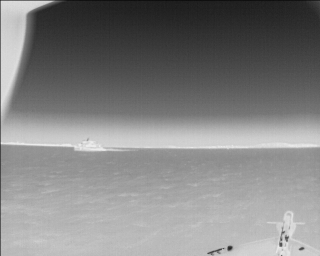

input image displayed


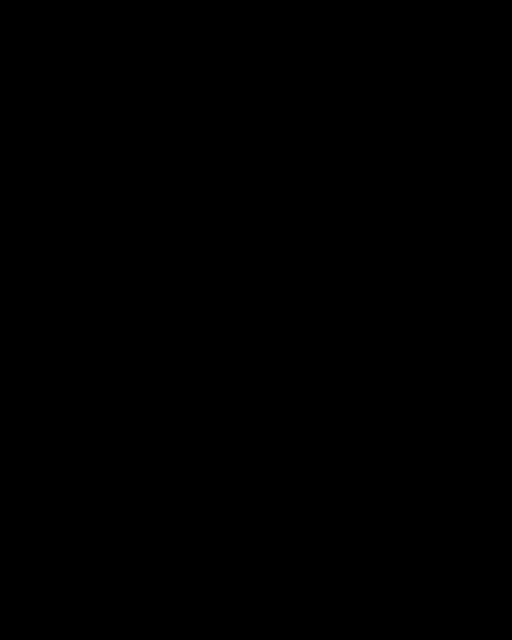

ground truth masked image displayed


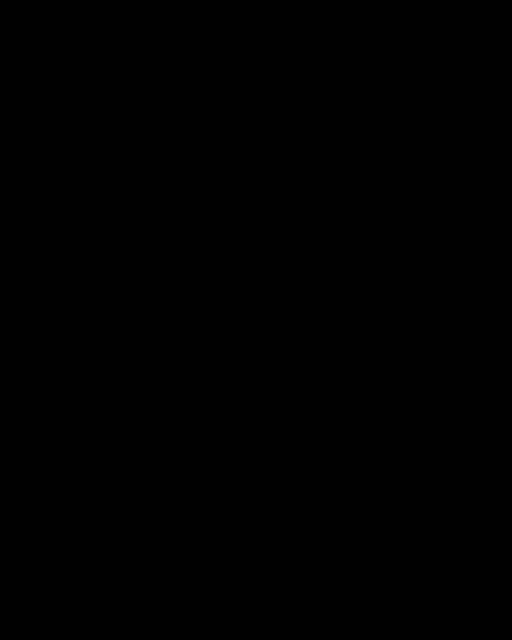

inference masked image displayed


In [6]:
#main.py 
import os
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint
#from UNet_model import create_model 
#from CreateImageDirPaths import createImageDirPaths 
#from DataSequence import MarineImages 
import PIL

import random
from tensorflow import keras
import numpy as np
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps



imageSize = (640, 512)
numClasses = 7
# sky:0, water:1, structure:2, Obstacle:3, living obstacle:4, background:5, self:6
batchSize = 5 # This may not be possible.
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

[input_img_paths, segmentation_img_paths] = createImageDirPaths()

print("input img paths = {0}".format(input_img_paths))
print("Type of input_img_paths = {0}".format(type(input_img_paths)))


# Build model
model = create_model(imageSize, numClasses)
model.summary()

# split image paths into a training and a validation set
validation_samples = 5
random.Random(15).shuffle(input_img_paths)
random.Random(15).shuffle(segmentation_img_paths)
train_input_img_paths = input_img_paths[:-validation_samples]
train_segmentation_img_paths = segmentation_img_paths[:-validation_samples]
validation_input_img_paths = input_img_paths[-validation_samples:]
validation_target_img_paths = segmentation_img_paths[-validation_samples:]

# Instantiate data Sequences for each split
marineData_training = MarineImages(batchSize, imageSize, train_input_img_paths, train_segmentation_img_paths)
marineData_validation = MarineImages(batchSize, imageSize, validation_input_img_paths, validation_target_img_paths)

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callback = [tf.keras.callbacks.ModelCheckpoint("uml_segmentation.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 10
model.fit(marineData_training, epochs=epochs, validation_data=marineData_validation, callbacks=callback)

"""Generate predictions for all images in the validation set."""
validation_gen = MarineImages(batchSize, imageSize, validation_input_img_paths, validation_target_img_paths)
validation_preds = model.predict(validation_gen)  
  
  
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(validation_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)
    
# Display results for validation image #3
i = 3

# Display input image
display(Image(filename=validation_input_img_paths[i]))
print ("input image displayed")

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(validation_target_img_paths[i]))
display(img)
print ("ground truth masked image displayed")

# Display mask predicted by our model
display_mask(i) 
print ("inference masked image displayed") 